## Tutorial 3 Querying niches across different technologies

In this section, we conducted niche query experiments on a Mouse Olfactory Bulb Tissue (MOBT) dataset.

In [ ]:
import os
import sys
import logging
import warnings
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

In [ ]:
import bench.bench_utils as bench_utils  # TODO: delete codebase
import models.model_utils as model_utils  # TODO: delete codebase
from models.trainer import QueSTTrainer
warnings.filterwarnings("ignore")
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

### Read and explore the data

In [ ]:
dataset = "MouseOlfactoryBulbTissue"
data_path = "./data/MOBT"
sample_ids = ["Stereo-seq", "10X", "Slide-seq V2"]
adata_list = [sc.read_h5ad(f"{data_path}/{data_id}.h5ad") for data_id in sample_ids]

This dataset included three samples generated by 10X Visium, Stereo-seq, and Slide-seq V2 technologies, with spot radius of 50 μm, 35 μm, and 10 μm, respectively.

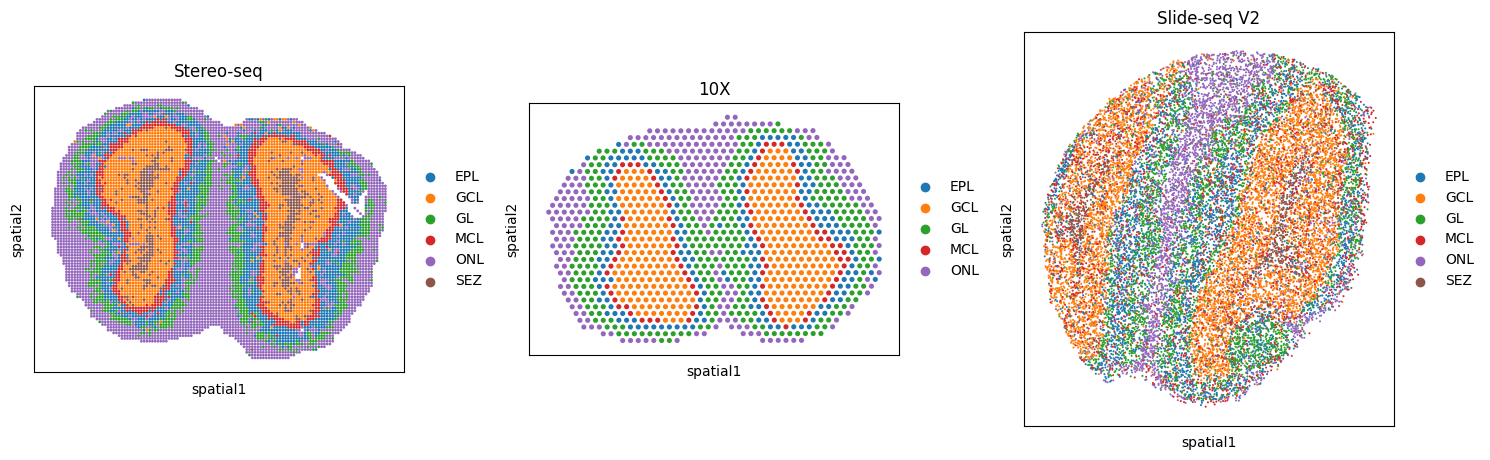

In [5]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
axes = axes.flatten()
for i, adata in enumerate(adata_list):
    spot_size = model_utils.get_spot_size(dataset=dataset, ref_id=adata.uns['library_id'])
    sc.pl.spatial(adata, color='layer', spot_size=spot_size, ax=axes[i], title=adata.uns['library_id'], show=False)
    axes[i].invert_yaxis()
fig.tight_layout()
fig.show()

We set the interface of the GCL and MCL layers as the query niche.

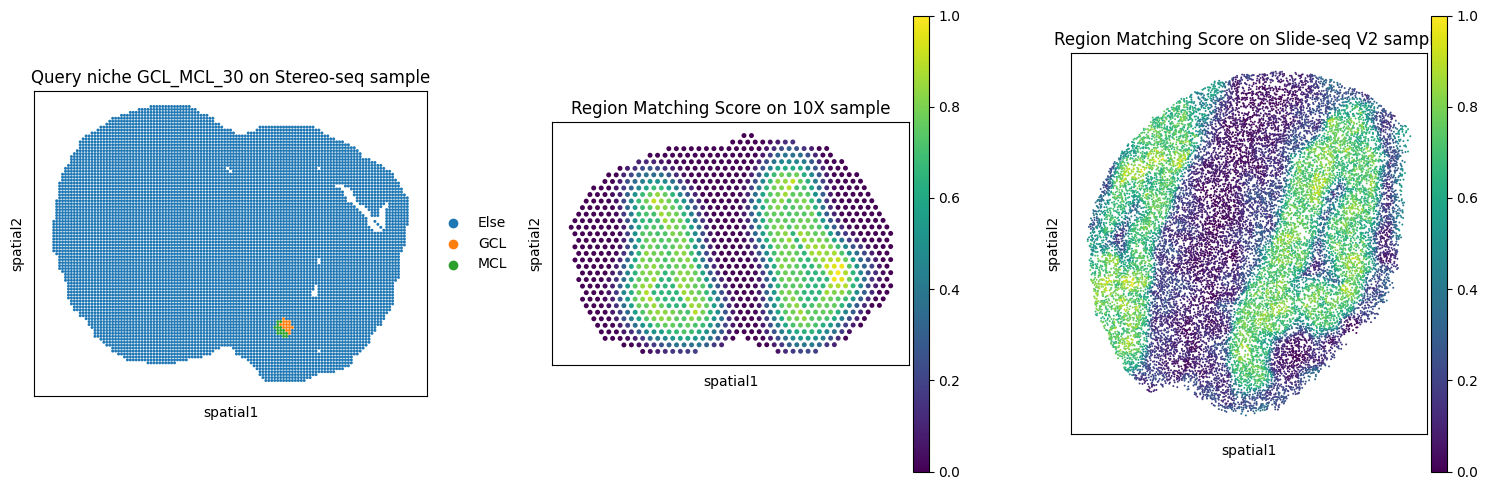

In [7]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
axes = axes.flatten()

for i, adata in enumerate(adata_list):
    spot_size = model_utils.get_spot_size(dataset=dataset, ref_id=adata.uns['library_id'])
    if adata.uns['library_id'] == "Stereo-seq":
        sc.pl.spatial(adata, color="GCL_MCL_30_layer", spot_size=spot_size, ax=axes[i], 
                      title="Query niche GCL_MCL_30 on Stereo-seq sample", show=False)
    else:
        sc.pl.spatial(adata, color='GCL_MCL_30_region_matching_score', spot_size=spot_size, ax=axes[i], 
                      title=f"Region Matching Score on {adata.uns['library_id']} sample", show=False)
    axes[i].invert_yaxis()
fig.tight_layout()
fig.show()

### Configure the niche query task

In [ ]:
query_sample_id = "Stereo-seq"
query_niches = ['GCL_MCL_30_niche']

### Set up QueST trainer

In [ ]:
trainer = QueSTTrainer(dataset=dataset, data_path=data_path, sample_ids=sample_ids, adata_list=adata_list,
                       query_niches=query_niches, query_sample_id=query_sample_id, 
                       model_path="./results/MOBT/model/quest_model.pth", 
                       epochs=20, save_model=True, hvg=None, min_count=0, normalize=False)

INFO:codebase.models.trainer:Processing arguments, time: 2025/05/04 17:14:37
INFO:codebase.models.trainer:using GPU 0
INFO:codebase.models.trainer:QueST Trainer initialized, loading data, time: 2025/05/04 17:14:37
INFO:codebase.models.trainer:Data loaded with 3 adata objects, time: 2025/05/04 17:14:37


### Train QueST model

In [10]:
trainer.train()

INFO:codebase.models.trainer:adata Stereo-seq has existing graph
INFO:codebase.models.trainer:adata 10X has existing graph
INFO:codebase.models.trainer:adata Slide-seq V2 has existing graph
INFO:codebase.models.model_utils:preprocessing adata, selecting common features
INFO:codebase.models.model_utils:gene num before intersection: [5531, 5531, 5531]
INFO:codebase.models.model_utils:5531 common genes identified
INFO:codebase.models.model_utils:gene num after intersection: [5531, 5531, 5531]
INFO:codebase.models.model_utils:filtering genes with min count=0
INFO:codebase.models.model_utils:5212 genes passed the filter with min count > 0, making adata copies
INFO:codebase.models.model_utils:Skip normalizing count
INFO:codebase.models.model_utils:Constructing spatial graph, computing 3-hop subgraph and creating batch labels for each sample! Batch num: 3
INFO:codebase.models.model_utils:getting feature: gene expression
INFO:codebase.models.model_utils:computing 3 hop subgraph for sample Ster

### Use trained QueST model to perform niche query

In [11]:
trainer.inference(save_embedding=False, query=True)

INFO:codebase.models.trainer:Loading model, time: 2025/05/04 17:25:42
INFO:codebase.models.trainer:Performing query: q_id=Stereo-seq, q_niche=GCL_MCL_30_niche, time: 2025/05/04 17:25:43
INFO:codebase.models.trainer:Processing 10X, saving predicted niche matching score to Anndata
INFO:codebase.models.trainer:Processing Slide-seq V2, saving predicted niche matching score to Anndata


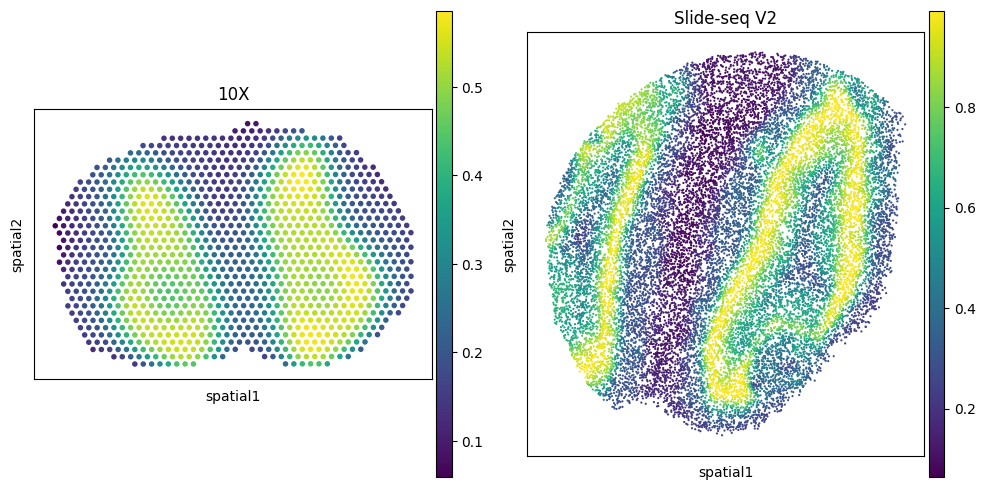

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axes = axes.flatten()
query_niche = query_niches[0]
adata_ref = trainer.adata_ref_list[0]
for i, adata_ref in enumerate(trainer.adata_ref_list):
    spot_size = model_utils.get_spot_size(dataset, adata_ref.uns['library_id'])
    sc.pl.spatial(adata_ref, color=f"{query_niche} predicted matching score", ax=axes[i], show=False, 
                  spot_size=spot_size, title=f"{adata_ref.uns['library_id']}")
    axes[i].invert_yaxis()
fig.tight_layout()
fig.show()